In [1]:
using Distributed
# Script for investigating amplitude dependence of potential
@everywhere using Distributions
@everywhere using Test
@everywhere using StatsBase
@everywhere using BenchmarkTools
@everywhere using LinearAlgebra
@everywhere using LaTeXStrings
using Dates
using Primes
using MCMCDiagnostics
using SharedArrays
using DelimitedFiles
#using JLD
@everywhere src_path = "../Source/"
@everywhere include(src_path*"types.jl")
@everywhere include(src_path*"functions_msc.jl")
@everywhere include(src_path*"functions_neighbors.jl")
@everywhere include(src_path*"functions_types.jl")
@everywhere include(src_path*"functions_energy.jl")
@everywhere include(src_path*"functions_mc.jl")
@everywhere include(src_path*"functions_thermalization.jl")
@everywhere include(src_path*"functions_observables.jl")
@everywhere include(src_path*"functions_symmetries.jl")
@everywhere include(src_path*"jackknife_estimates.jl")
@everywhere include(src_path*"dist_lists.jl")
@everywhere include(src_path*"parallel_tempering.jl")
include(src_path*"functions_plots_and_files.jl")
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using JLD

# Exploring results

#### Navigating to folder

In [8]:
pwd()

"/home/nicolai/Documents/Work/PhD/Numerikk/MC/finite-temp-vortex-lattice/Scripts/two_comp_london_T=0.7-3.32_L=32_g=0.447"

In [7]:
cd("../Scripts/two_comp_london_T=0.7-3.32_L=32_g=0.447/")

#### Energy

In [9]:
ens = readdlm("energies.data", ':', Float64);
size(ens, 2)

8192

In [10]:
meta_di = JLD.load("meta.jld")
f = meta_di["f"]; L₃ = meta_di["L3"]; M = meta_di["M"]; temps = meta_di["temps"]; κ₅ = meta_di["kappa"];
Δt = meta_di["dt"]; L = meta_di["L"]; g = meta_di["g"]; ν = meta_di["nu"]

32

In [11]:
N = L^2*L₃;
N_T = length(temps)

3

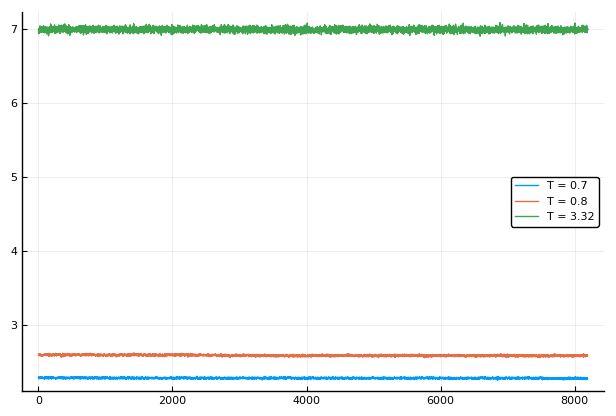

In [12]:
plt = plot([ens[k, :]./N for k = 1:N_T]; label=reshape(["T = $(round(T, digits=2))" for T in reverse(temps)], 1, N_T))
savefig(plt, "measure_energies.pdf")

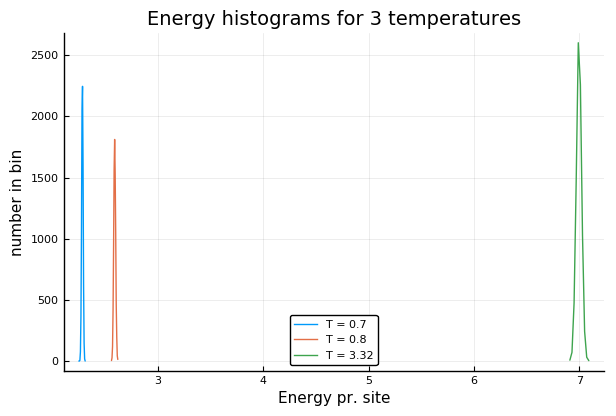

In [111]:
# Plot energy histograms
E_by_T = [ens[k, :] for k = 1:N_T]
plotEnergyHistograms(E_by_T./N, reverse(temps));

#### Dual Stiffness

In [13]:
dual = readdlm("dual_stiffs.data", ':', Float64);
ρˣ₂_by_T = [dual[k, :] for k = 1:N_T];
size(dual, 2)

8192

In [40]:
dual_di = JLD.load("dual_stiffs.jld");
ρˣ₂_by_T_jld = dual_di["x2"]
ρˣ₃_by_T = dual_di["x3"]
ρʸ₁_by_T = dual_di["y1"]
ρʸ₃_by_T = dual_di["y3"]
ρᶻ₁_by_T = dual_di["z1"]
ρᶻ₂_by_T = dual_di["z2"]
println(ρˣ₂_by_T == ρˣ₂_by_T_jld)

true


Plotting some variance graphs and making jackknife estimates

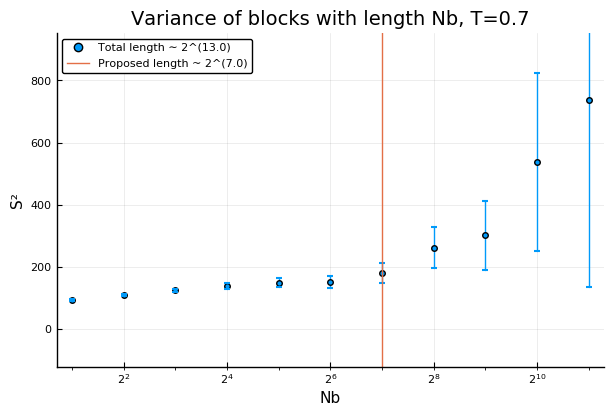

In [44]:
num_blocks = 2^6
varianceByBlockLengthPlots(ρˣ₂_by_T, E_by_T, [1/T for T in temps]; num_blocks=num_blocks)

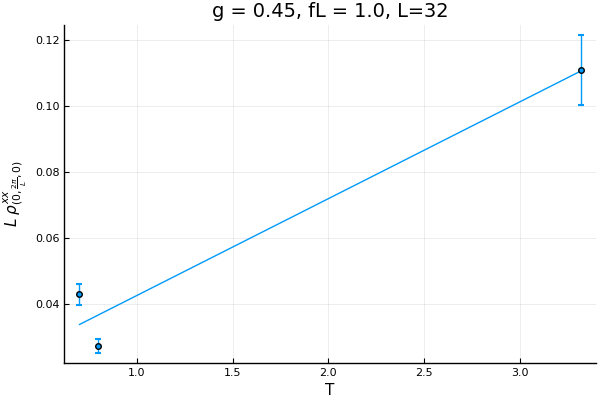

In [106]:
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
for i = 1:N_T
    jv = jackVars(mean, ρˣ₂_by_T[i], num_blocks; skip_check=true)
    ρˣ₂_avg_by_T[i], var = jackEstimate(jv)
    ρˣ₂_err_by_T[i] = √(var)
end
plt = scatter(reverse(temps), L.*ρˣ₂_avg_by_T, yerror=L.*ρˣ₂_err_by_T; 
    smooth=true, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")

Construct jackknife estimates for the rest of the components and save in separate folder

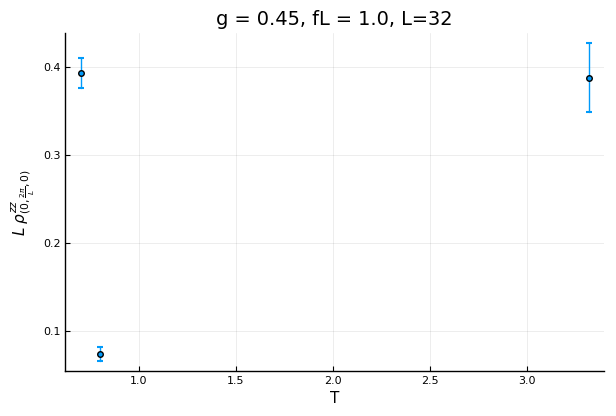

In [105]:
mkcd("dual_gauge_stiffness")
ρˣ₃_avg_by_T = Array{Float64}(undef, N_T); ρˣ₃_err_by_T = Array{Float64}(undef, N_T);
ρˣ₂_avg_by_T = Array{Float64}(undef, N_T); ρˣ₂_err_by_T = Array{Float64}(undef, N_T);
ρʸ₁_avg_by_T = Array{Float64}(undef, N_T); ρʸ₁_err_by_T = Array{Float64}(undef, N_T);
ρʸ₃_avg_by_T = Array{Float64}(undef, N_T); ρʸ₃_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₁_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₁_err_by_T = Array{Float64}(undef, N_T);
ρᶻ₂_avg_by_T = Array{Float64}(undef, N_T); ρᶻ₂_err_by_T = Array{Float64}(undef, N_T);
for k = 1:N_T
    jv_x2 = jackVars(mean, ρˣ₂_by_T[k], num_blocks; skip_check=true)
    jv_x3 = jackVars(mean, ρˣ₃_by_T[k], num_blocks; skip_check=true)
    jv_y1 = jackVars(mean, ρʸ₁_by_T[k], num_blocks; skip_check=true)
    jv_y3 = jackVars(mean, ρʸ₃_by_T[k], num_blocks; skip_check=true)
    jv_z1 = jackVars(mean, ρᶻ₁_by_T[k], num_blocks; skip_check=true)
    jv_z2 = jackVars(mean, ρᶻ₂_by_T[k], num_blocks; skip_check=true)
    
    ρˣ₂_avg_by_T[k], var_x2 = jackEstimate(jv_x2); ρˣ₃_avg_by_T[k], var_x3 = jackEstimate(jv_x3)
    ρʸ₁_avg_by_T[k], var_y1 = jackEstimate(jv_y1); ρʸ₃_avg_by_T[k], var_y3 = jackEstimate(jv_y3)
    ρᶻ₁_avg_by_T[k], var_z1 = jackEstimate(jv_z1); ρᶻ₂_avg_by_T[k], var_z2 = jackEstimate(jv_z2)
    
    ρˣ₂_err_by_T[k] = √(var_x2); ρˣ₃_err_by_T[k] = √(var_x3)
    ρʸ₁_err_by_T[k] = √(var_y1); ρʸ₃_err_by_T[k] = √(var_y3)
    ρᶻ₁_err_by_T[k] = √(var_z1); ρᶻ₂_err_by_T[k] = √(var_z2)
end

plt = scatter(reverse(temps), L.*ρˣ₂_avg_by_T, yerror=L.*ρˣ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, \frac{2\pi}{L}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
savefig(plt, "gauge_stiff_x2.png")
#plt1 = scatter(reverse(temps), L.*ρˣ₃_avg_by_T, yerror=L.*ρˣ₃_err_by_T;
#    smooth=false, xlabel="T", ylabel=L"L\;\rho^{xx}_{(0, 0, \frac{2\pi}{L})}", label="",
#    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
#savefig(plt1, "gauge_stiff_x3.png")
plt = scatter(reverse(temps), L.*ρʸ₁_avg_by_T, yerror=L.*ρʸ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(\frac{2\pi}{L}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
savefig(plt, "gauge_stiff_y1.png")
plt = scatter(reverse(temps), L.*ρʸ₃_avg_by_T, yerror=L.*ρʸ₃_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{yy}_{(0, 0, \frac{2\pi}{L})}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
savefig(plt, "gauge_stiff_y3.png")
plt = scatter(reverse(temps), L.*ρᶻ₁_avg_by_T, yerror=L.*ρᶻ₁_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(\frac{2\pi}{L}, 0, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
savefig(plt, "gauge_stiff_z1.png")
plt = scatter(reverse(temps), L.*ρᶻ₂_avg_by_T, yerror=L.*ρᶻ₂_err_by_T;
    smooth=false, xlabel="T", ylabel=L"L\;\rho^{zz}_{(0, \frac{2\pi}{L}, 0)}", label="",
    title="g = $(round(g; digits=2)), fL = $(round(f*L; digits=2)), L=$(L)")
savefig(plt, "gauge_stiff_z2.png")

cd("../")

#### Specific heat

In [119]:
function specificHeat(energies::Array{T, 1}, β::T) where T<:Real
    return var(energies)*β^2
end

specificHeat2 (generic function with 1 method)

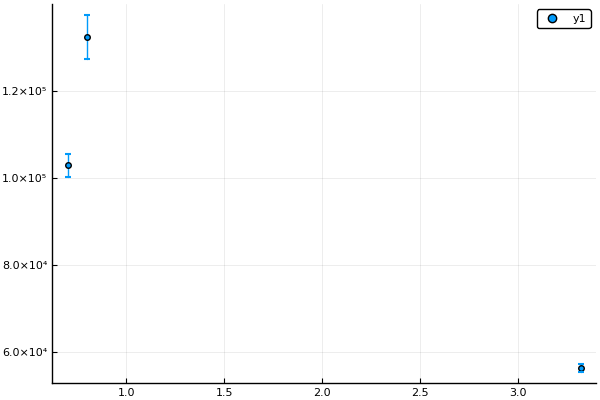

In [126]:
Cv_avg_by_T = Array{Float64, 1}(undef, N_T)
Cv_err_by_T = Array{Float64, 1}(undef, N_T)
for k = 1:N_T
    jv = jackVars(energies -> specificHeat(energies, 1/reverse(temps)[k]), E_by_T[k], num_blocks; skip_check=true)
    Cv_avg_by_T[k], var = jackEstimate(jv)
    Cv_err_by_T[k] = √(var)
end
scatter(reverse(temps), Cv_avg_by_T, yerror=Cv_err_by_T)

#### Vorticity

In [18]:
vo_di = JLD.load("vorticity.jld")

Dict{String,Any} with 3 entries:
  "sp"       => Array{Array{Float64,2},1}[[[446.717 6.11479 … 83.8111 23.705; 3…
  "sm"       => Array{Array{Float64,2},1}[[[393.842 206.714 … 265.009 1022.84; …
  "vortexes" => Tuple{Array{Float64,3},Array{Float64,3}}[([0.245632 -6.10273 … …

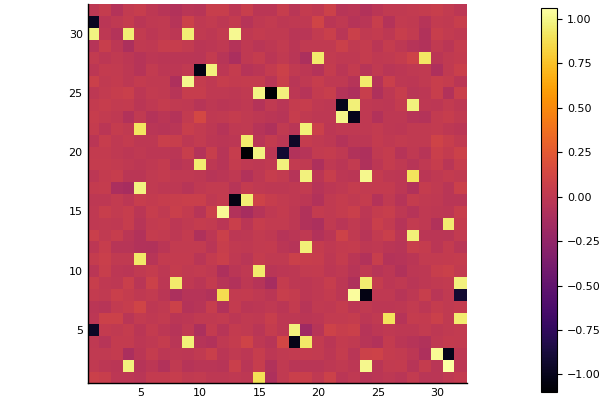

In [19]:
vortices_by_T = vo_di["vortexes"];
V⁺_by_T = [vortices_by_T[k][1] for k = 1:N_T]
heatmap(V⁺_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi; aspect_ratio=1.0)

In [20]:
# Check that the net vorticity is ≈ fL
for k = 1:N_T
    for z = 1:L₃
        @test isapprox(sum(V⁺_by_T[1][:,:,z]./two_pi), sum(V⁺_by_T[k][:,:,z]./two_pi))
    end
end
sum(V⁺_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi)

32.0

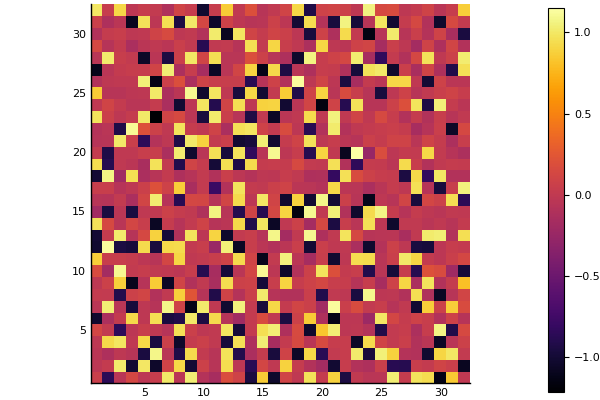

In [21]:
heatmap(V⁺_by_T[3][:,:,8]./two_pi; aspect_ratio=1.0)

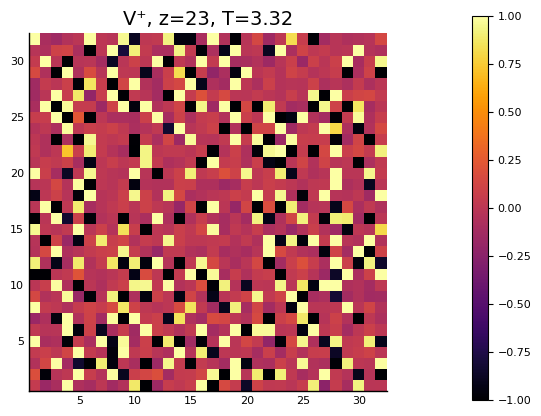

In [22]:
mkcd("V+")
for k = 1:N_T
    layer = rand(1:L₃)
    V⁺ = V⁺_by_T[k][:,:,layer]./two_pi
    temp = round(reverse(temps)[k], digits=2)
    plt = heatmap(V⁺; aspect_ratio=1.0, clims=(-1, 1), title="V⁺, z=$(layer), T=$(temp)")
    savefig(plt, "V+_avg_T=$(temp).png")
end
cd("../")

Negative component:

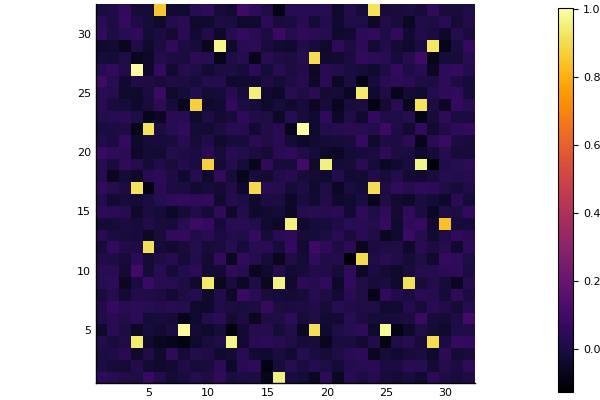

In [23]:
vortices_by_T = vo_di["vortexes"];
V⁻_by_T = [vortices_by_T[k][2] for k = 1:N_T]
heatmap(V⁻_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi; aspect_ratio=1.0)

In [24]:
for k = 1:N_T
    for z = 1:L₃
        @test isapprox(sum(V⁻_by_T[1][:,:,z]./two_pi), sum(V⁻_by_T[k][:,:,z]./two_pi))
    end
end
sum(V⁻_by_T[rand(1:N_T)][:,:,rand(1:L₃)]./two_pi)

31.999999999999996

We have varying sum of net vorticity between about [12, 17]

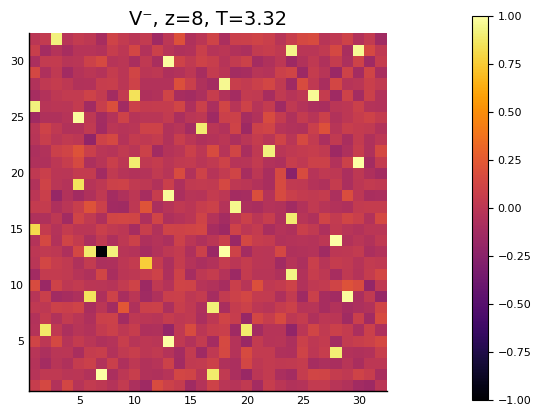

In [25]:
mkcd("V-")
for k = 1:N_T
    layer = rand(1:L₃)
    V⁻ = V⁻_by_T[k][:,:,layer]./two_pi
    temp = round(reverse(temps)[k], digits=2)
    plt = heatmap(V⁻; aspect_ratio=1.0, clims=(-1, 1), title="V⁻, z=$(layer), T=$(temp)")
    savefig(plt, "V-_avg_T=$(temp).png")
end
cd("../")

#### Structure factor

In [26]:
S⁺_by_T = vo_di["sp"];
println("Measures $(length(S⁺_by_T[1]))")
println("Maximum: $(maximum(S⁺_by_T[rand(1:N_T)][rand(1:M)])/(L^2*f*two_pi)^2)")
# Normalizing structure function
normalization = (L^2*f*two_pi)^2
S⁺_by_T = [S⁺_measures./normalization for S⁺_measures in S⁺_by_T];

Measures 8192
Maximum: 1.0000000000000004


In [27]:
# Removing mid-point of L×L matrix
function removeMiddle(A::Array{T, 2}) where {T}
    L = size(A, 1)
    L_mid = floor(Int64, L/2)+1
    val = A[1,1]
    A′ = copy(A)
    A′[L_mid-1, L_mid] = val
    A′[L_mid-1, L_mid-1] = val
    A′[L_mid-1, L_mid+1] = val
    A′[L_mid-2, L_mid] = val
    A′[L_mid, L_mid] = val
    #A′[L_mid, L_mid+1] = val
    A′
end

removeMiddle (generic function with 1 method)

1.0


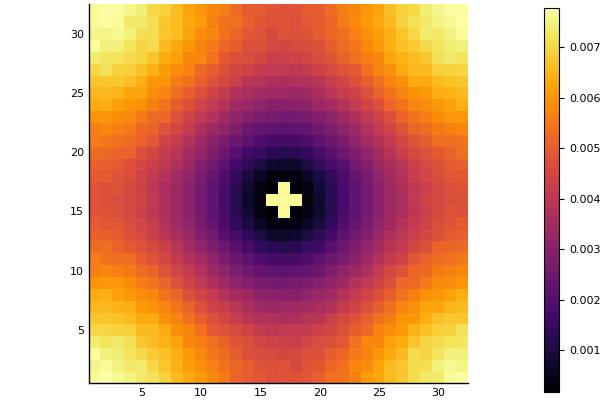

In [28]:
# Finding if there is correct normalization
S⁺_avg = mean(S⁺_by_T[rand(1:N_T)]);
println(maximum(S⁺_avg))
heatmap(removeMiddle(S⁺_avg); aspect_ratio=1.0)

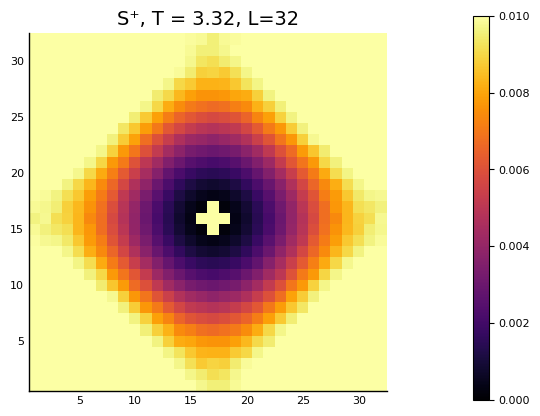

In [38]:
mkcd("S+")
for k = 1:N_T
    T = round(reverse(temps)[k]; digits=2)
    S⁺_avg = mean(S⁺_by_T[k])
    plt = heatmap(removeMiddle(S⁺_avg); aspect_ratio=1.0, title="S⁺, T = $(T), L=$(L)", clims=(0, 0.01))
    savefig(plt, "S+_avg_T=$(T)")
end
cd("../")

Negative component

In [30]:
S⁻_by_T = vo_di["sm"];
println("Measures $(length(S⁻_by_T[1]))")
println("Maximum: $(maximum(S⁻_by_T[rand(1:N_T)][rand(1:M)])/(L^2*f*two_pi)^2)")
# Normalizing structure function
normalization = (L^2*f*two_pi)^2
S⁻_by_T = [S⁻_measures./normalization for S⁻_measures in S⁻_by_T];

Measures 8192
Maximum: 1.0000000000000002


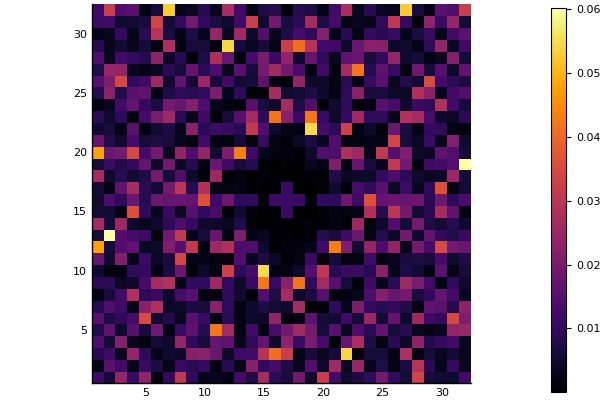

In [35]:
S⁻_avg = mean(S⁻_by_T[1])
heatmap(removeMiddle(S⁻_avg); aspect_ratio=1.0)

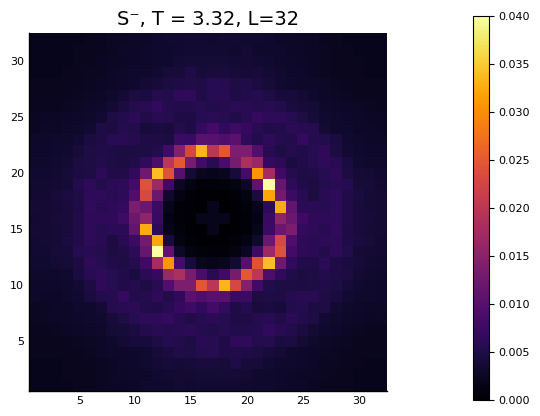

In [37]:
mkcd("S-")
for k = 1:N_T
    T = round(reverse(temps)[k]; digits=2)
    S⁻_avg = mean(S⁻_by_T[k])
    plt = heatmap(removeMiddle(S⁻_avg); aspect_ratio=1.0, title="S⁻, T = $(T), L=$(L)", clims=(0, 0.04))
    savefig(plt, "S-_avg_T=$(T)")
end
cd("../")